# One dimensional posterior distribution

say we have data $y=[y_0, y_1, ... , y_n]$ observed at times $t=[t_0, t_1, ... , t_n]$

Our <b>model</b> will be 
$$M_A: y_A(t;\omega)=sin(\omega t)$$

We have only one model parameter $\theta =[\omega]$\
$\omega$ is the only parameter this model has


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def modelA (time,omega):
    return np.sin(omega*time)

Simulate some data

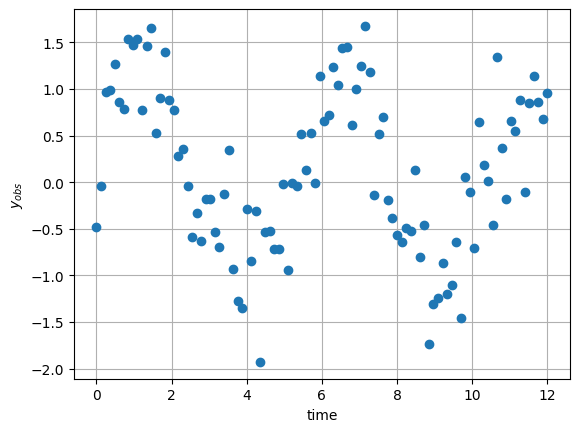

In [2]:
sigma = 0.5 # SD of noise
omega_true=1.2

time=np.linspace(0,12,100)
y_det=modelA(time=time, omega=omega_true) # model
y_obs=y_det+np.random.normal(0,sigma,len(time)) # Observed signal+gaussian noise

plt.figure("Observed signal")
plt.plot(time, y_obs,'o')
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.grid()
plt.show()

Now we need to figure out the frequency of this data which is "omega_true". We put this in ofcourse, but let's pretend we didn't know its value.

We start from the statement that $y_{obs}=y_{det}+noise$.\
Therefore $noise=y_{obs}-y_{det}$

This is enough to wrote down the <b>likelihood</b>.
$$L(y_i,t_i|\omega, M_A, \sigma = 0.5) = Normal(y - y_A(t|\omega)|\sigma=0.5)$$

here $(y_i, t_i)$ is a data point

The likelihood of $y_i,t_i$ given $\omega, M_A, \sigma = 0.5$ is just the normal distribution where we subtract the model $y_A(t_i)$ from the observed data $(y_i)$. Then we are left with just the noise.

This is expressed as: 
$$
    L(y_i,t_i|\omega, M_A, \sigma = 0.5) ={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(y_i-y_A(t_i))^2}{2\sigma ^{2}}}}
$$ (1)


This comes from the PDF of a normal distribution whcih is:
<span style='color:yellow'>
$${\displaystyle f(x)={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$$
</span>

Working with <b>log likelihood</b> we get 

$$
\boxed{
ln\ L(y_i,t_i|\omega, M_A, \sigma = 0.5) = - \frac{1}{2}(\frac {(y_i-y_A(t_i))^2}{\sigma^2} + ln(2\pi\sigma^2))
}
$$

Now the log likelihood of all the data instead of just the $i^{th}$ component is:
$$L(y,t|\omega, M_A, \sigma = 0.5) = \prod_{i} {L(y_i,t_i|\omega, M_A, \sigma = 0.5)}$$

Or,
log of the product is the summation.

$$
\boxed{
    ln\ L(y,t|\omega, M_A, \sigma = 0.5) = \sum_{i} {ln\ L(y_i,t_i|\omega, M_A, \sigma = 0.5)}
}
$$

### Likelihood of omega:

Insted of the prior we are using the grid here

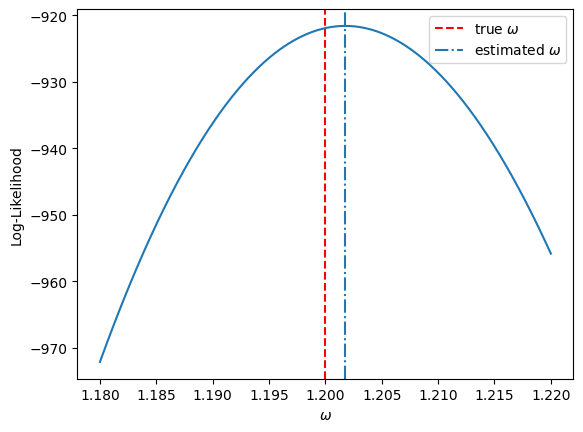

In [3]:
def ln_likelihood(y_obs, time, omega, sigma=0.1):
    y_A = modelA(time, omega) # the model
    ln_likes = -0.5*((y_obs-y_A)**2/ sigma**2 + np.log(2*np.pi*sigma**2)) 
    # the log likelihood equation
    return np.sum(ln_likes) # sum of all elements

# using a grid instead of the priors
omega_grid = np.linspace(omega_true-2e-2, omega_true+2e-2, 1000)
ln_likelihood_grid=[]
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(y_obs, time, omega))

plt.figure('Likelihood estimates for omega')
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls='--', color='red', label="true $\omega$")

max_likelihood_omega=omega_grid[np.argmax(ln_likelihood_grid)] 
# Maximum likelihood estimate for omega

plt.axvline(max_likelihood_omega, ls='-.', label="estimated $\omega$")
plt.xlabel('$\omega$')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.show()

We can see that the estimated $\omega$ value is very close to the true $\omega$ value!

### Plotting Maximum Likelihood through posterior predictive checking

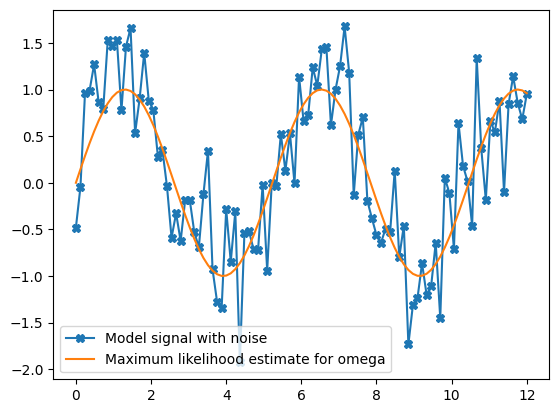

In [4]:
plt.figure("Maximum Likelihood for omega")
plt.plot(time, y_obs, '-X', label="Model signal with noise")
plt.plot(time, modelA(time, max_likelihood_omega), label="Maximum likelihood estimate for omega")
plt.legend()
plt.show()

If prior $\pi(\omega)$ is constant we can ignore it. In most cases we won't. But just for the sake of the example here we will ignore it.

### Normalizing the log likelihood to get the posterior density function (PDF)

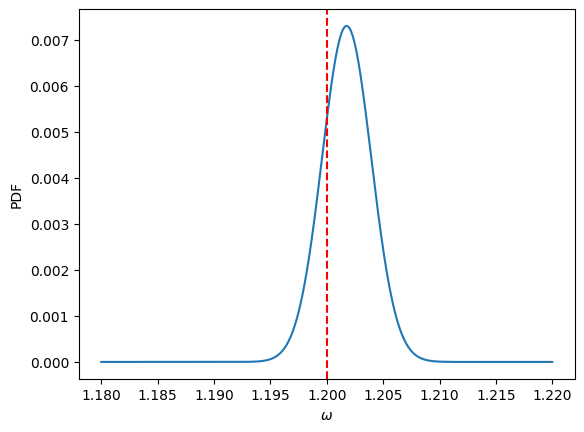

In [5]:
pdf_unnormalized=np.exp(ln_likelihood_grid-np.mean(ln_likelihood_grid))
pdf_normalized = pdf_unnormalized/ np.sum(pdf_unnormalized)

plt.figure('Normalized PDF for omega')
plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--', color='red', label="true $\omega$")
plt.xlabel('$\omega$')
plt.ylabel('PDF')
plt.show()

The same process of finding the likelihood using bilby would look like this:

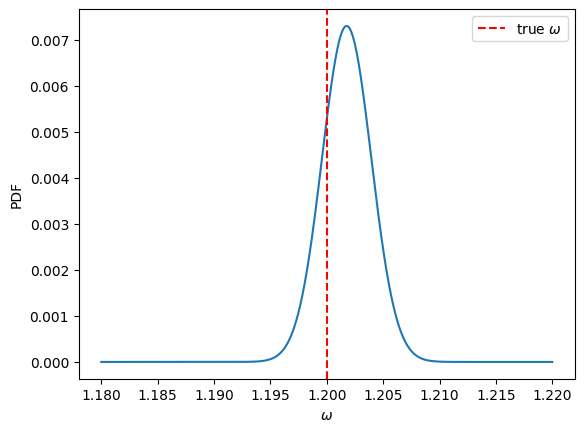

In [6]:
import  bilby

likelihood = bilby.likelihood.GaussianLikelihood(time, y_obs, modelA, sigma=0.1) 

ln_likelihood_grid_bilby=[]
for omega in omega_grid:
    likelihood.parameters["omega"]=omega
    ln_likelihood_grid_bilby.append(likelihood.log_likelihood()) 
    # taking log of the likelihood function

plt.figure('Normalized PDF using Bilby')
pdf_unnormalized=np.exp(ln_likelihood_grid_bilby - 
                            np.mean(ln_likelihood_grid_bilby))
plt.plot(omega_grid, pdf_unnormalized / np.sum(pdf_unnormalized))
plt.axvline(omega_true, ls='--', color='red', label="true $\omega$")
plt.xlabel('$\omega$')
plt.ylabel('PDF')
plt.legend()
plt.show()


We can see that the peak of the PDF doesn't align with the true value of $\omega$. This is due to the noise which introduces uncertainty. But this noise can be quantified using the <b>credible interval</b>

### Cumulative Density Function (CDF)

$$CDF(\omega) = \int_{-\infty}^{\omega} P(\omega|data) \,dw\ $$

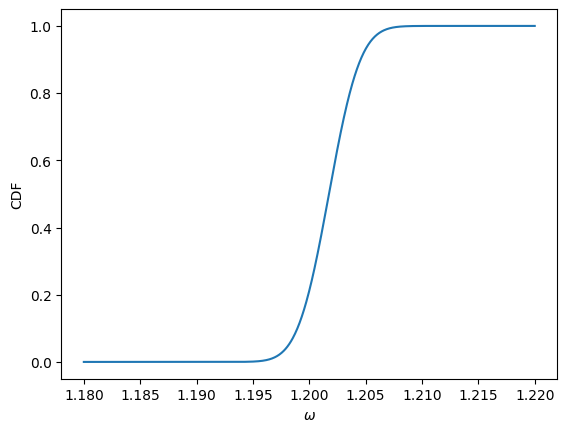

In [7]:
cdf=np.cumsum(pdf_normalized)

plt.figure('CDF of omega')
plt.plot(omega_grid, cdf)
plt.xlabel('$\omega$')
plt.ylabel('CDF')
plt.show()

### Defining a confidence interval
Now we just need to look for an interval in the CDF which includes 95% of the posterior

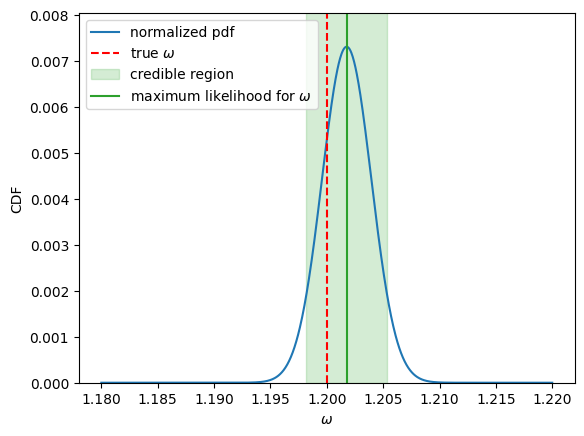

In [8]:
median=omega_grid[np.argmin(np.abs(cdf-0.5))] # This is the same as
                                              # max_likelihood_omega
lower_bound=omega_grid[np.argmin(np.abs(cdf-0.05))]
upper_bound=omega_grid[np.argmin(np.abs(cdf-0.95))]
 
plt.figure('Credible regions of the PDF')
plt.plot(omega_grid, pdf_normalized, label='normalized pdf')
plt.axvline(omega_true, ls='--', color='red', label='true $\omega$')
plt.fill_between([lower_bound, upper_bound], 0, 2* np.max(pdf_normalized), 
                color='C2', alpha=0.2, label='credible region')
                #([x limits], lower limit for y, upper limit for y)
plt.axvline(max_likelihood_omega, color='C2',
            label='maximum likelihood for $\omega$')
plt.ylim(0, 1.1 * np.max(pdf_normalized))
plt.xlabel('$\omega$')
plt.ylabel('CDF')
plt.legend()
plt.show()




We can see that the true value of $\omega$ lies within the confidence interval of the PDF and it will do so 90% of the time. But when we get to higher dimensions (more parameters) we should rely on stochastic (random) sampling algorithms. 

The edges of this green region appreas as dotted lines in the final plot which define the confidence interval.


# Peak finding algorithm

Finds the highest likelihood value but does not give any information on the shape of the distribution.

# Metropolis-Hastings algorithm

This gives us the distribution due to its inherent randomness.

The sampler will have a list of points that are sampled from the posterior distribution including many repeated points.
When these points are "cleaned" and binned into a histogram we get a nice representation of that posterior distribution.\
The same thing that we did before we the grid we are now doing with a histogram. 

When we run a stochastic sampler this is the key output. this is what will give us the value of that parameter along with the confidence intervals